In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters

from torch.autograd import Variable

import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm

from matplotlib import pyplot as plt

In [2]:
# read the data
data = pd.read_csv('FFData.CSV')

MKT = data["Mkt-RF"]
MKT = MKT.to_numpy().reshape(-1,1)

SMB = data["SMB"]
SMB = SMB.to_numpy().reshape(-1,1)

HML = data["HML"]
HML = HML.to_numpy().reshape(-1,1)

RF = data["RF"]
RF = RF.to_numpy().reshape(-1,1)

# training data
index_1927 = data["Year"].to_list().index(1927)

MKT_t = MKT[index_1927:,:]
SMB_t = SMB[index_1927:,:]
HML_t = HML[index_1927:,:]
RF_t = RF[index_1927:,:]

# testing data
MKT_te = MKT[0:index_1927-1,:]
SMB_te = SMB[0:index_1927-1,:]
HML_te = HML[0:index_1927-1,:]
RF_te = RF[0:index_1927-1,:]


# data standardization
MKT_t =(MKT_t-np.mean(MKT_t))/np.std(MKT_t)
SMB_t =(SMB_t-np.mean(SMB_t))/np.std(SMB_t)
HML_t =(HML_t-np.mean(HML_t))/np.std(HML_t)
RF_t =(RF_t-np.mean(RF_t))/np.std(RF_t)

MKT_te =(MKT_te-np.mean(MKT_te))/np.std(MKT_te)
SMB_te =(SMB_te-np.mean(SMB_te))/np.std(SMB_te)
HML_te =(HML_te-np.mean(HML_te))/np.std(HML_te)
RF_te =(RF_te-np.mean(RF_te))/np.std(RF_te)

# testing using data from 1927-01 to 2021-12
index_192701 = data["Year"].to_list().index(192701)
index_202112 = data["Year"].to_list().index(202112)
MKT_te = np.repeat(MKT_t, 12).reshape(-1,1) # use yearly MKT as x for testing data
SMB_te = SMB_te[index_192701:index_202112+1,:]
HML_te = HML_te[index_192701:index_202112+1,:]
RF_te = RF_te[index_192701:index_202112+1,:]

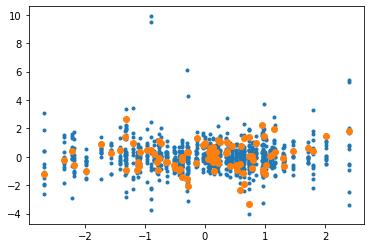

In [3]:
plt.plot(MKT_te,HML_te,'.')
plt.plot(MKT_t,HML_t,'o')
plt.show()

In [4]:
# Liang's method with rbf m(x) and quad v(x); x = MKT, y = HML

# X = MKT_t
# Y = HML_t

X = MKT_t[0:60,:]
Y = HML_t [0:60,:]
X_h = MKT_t[60:,:]
Y_h = HML_t[60:,:] #split the data to training set and calibration set

X_te = MKT_te
Y_te = HML_te

n = len(X)
n_h = len(X_h)
n_te = len(X_te)

def sdpDual(K1, K2, Y, n, gamma = 1e1):
    sqrt_K1 = sqrtm(K1)
    hB = cp.Variable((n,n), symmetric=True)
    ha = cp.Variable(n)
    constraints = [hB >> 0] 
    constraints += [K2[i,:]@hB@K2[i,:] >= cp.square(Y[i] - K1[i,:]@ha) for i in range(n) ]
    #prob = cp.Problem(cp.Minimize( gamma*cp.quad_form(ha, K1) + cp.trace(K2@hB)), constraints)
    prob = cp.Problem(cp.Minimize(gamma*cp.norm(sqrt_K1@ha,2)**2+cp.trace(K2@hB)), constraints)
    prob.solve() 
    return [ha.value , hB.value]


X_diff = np.power(X @ np.ones((n, 1)).T - np.ones((n, 1)) @ X.T, 2)
sigma = 1.0
K1 = np.exp(-(1 / (2 * sigma)) * X_diff)

degree = 2
K2 = np.power(1+X @ X.T, degree)

a,B = sdpDual(K1,K2,Y,n,gamma=0.1)


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [5]:
# K1 psd problem
print(np.all(np.linalg.eigvals(K1) >= 0))
print(np.all(np.linalg.eigvals(K1) >= -1e-10))

False
True


In [6]:
# learn delta
X_hold_diff = np.power(X_h @ np.ones((n, 1)).T - np.ones((n_h, 1)) @ X.T, 2)
K1_hold = np.exp(-(1 / (2 * sigma)) * X_hold_diff)
X_test_diff = np.power(X_te @ np.ones((n, 1)).T - np.ones((n_te, 1)) @ X.T, 2)
K1_test = np.exp(-(1 / (2 * sigma)) * X_test_diff)


K2_hold = np.power(1+X @ X_h.T, degree)
K2_test = np.power(1+X @ X_te.T, degree)
V_hat_hold = np.diag(K2_hold.T @ B @ K2_hold)
V_hat_test = np.diag(K2_test.T @ B @ K2_test)

alpha = 0.05
delta = -1
Delta = 3
prop = 0.5
prop_outside = (np.power(Y_h[:,0]-K1_hold@a, 2) > (1 + delta) * V_hat_hold).mean()
while prop_outside > (0.75 * alpha):
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_h[:,0]-K1_hold@a, 2) > (1 + delta) * V_hat_hold).mean()

test_prop = (np.power(Y_te[:,0]-K1_test@a, 2) > (1 + delta) * V_hat_test).mean()
interval_length = np.mean(2 * np.sqrt((1 + delta) * V_hat_test))
print("The overall coverage is", 1-test_prop)
print("The mean bandwidth is", interval_length)
print("delta is", delta)

The overall coverage is 0.9833333333333333
The mean bandwidth is 5.546233784507324
delta is 1.0


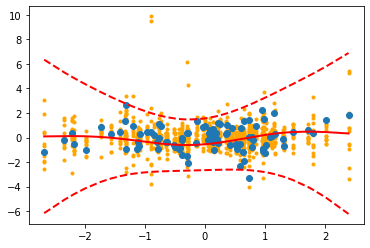

In [7]:
# plot the result
X_plot = X_te
Y_plot = Y_te


X_sort = np.sort(X_plot, axis=0)
X_sort_indices = np.argsort(X_plot, axis=0)
Y_sort = Y_plot[X_sort_indices[:, 0]]
lower_CI = K1_test@a-np.sqrt((1 + delta) * V_hat_test)
lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
upper_CI = K1_test@a+np.sqrt((1 + delta) * V_hat_test)
upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
mean_value = K1_test@a
mean_value_sort = mean_value[X_sort_indices[:, 0]]


plt.plot(X_sort, Y_sort, '.',color='orange')
plt.plot(MKT_t,HML_t,'o')
plt.plot(X_sort, mean_value_sort, '-r', lw=2)
plt.plot(X_sort, lower_CI_sort, '--r', lw=2)
plt.plot(X_sort, upper_CI_sort, '--r', lw=2)
plt.show()